# data loading

In [1]:
from data_loader import Data_loader

# 用前2/3的数据用于训练,后1/3数据用于测试
# window_length = 1.5 years

dl = Data_loader()
start_idx = 0
window_train, window_test = dl.get_window(start_idx=start_idx)

# 在每个window内筛选paris



## 1.normalized price distance初筛

Basic Statistics for distances:
Mean: 5286219.084745647
Median: 16.611412381093956
Standard Deviation: 114968276.66669613

Percentiles:
0th percentile: 0.06935615485767097
25th percentile: 6.543446734558261
50th percentile: 16.611412381093956
75th percentile: 41.862403733135274
100th percentile: 2763430370.728946

Minimum: 0.06935615485767097
Maximum: 2763430370.728946


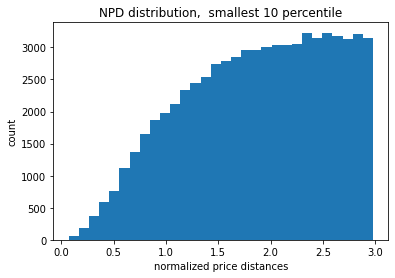

In [ ]:
from pair_filter import NPD_filter

NPD = NPD_filter(window_train)

NPD.visualize_price_distance()


In [ ]:
pairs, distance = NPD.select_pairs(percentile=5, verbose=True)

34018 pairs selected
min distance 0.06935615485767097
max distance 1.921438805060201


## 2.OLS regressin进一步筛选

$y_{1, t} = \gamma * y_{2, t} + \mu + \epsilon_{t}$

测试epsilon是否staionary

In [ ]:
from pair_filter import OLS_filter

OLS = OLS_filter(window_train)

pairs, params = OLS.select_pairs(pairs, verbose=True)

11323 out of 34018 pairs passed the test
pass rate: 0.33


## cache pairs, params

In [ ]:
# import pickle
# import os

# # 确保 cache 文件夹存在
# os.makedirs('cache', exist_ok=True)

# # 组合数据
# data = {'pairs': pairs, 'params': params}

# # 保存
# with open('cache/pairs_params.pkl', 'wb') as f:
#     pickle.dump(data, f)

# print("Saved to cache/pairs_params.pkl ✅")


Saved to cache/pairs_params.pkl ✅


In [2]:
import pickle

with open('cache/pairs_params.pkl', 'rb') as f:
    data = pickle.load(f)

pairs = data['pairs']
params = data['params']

# optimizers

In [ ]:
from optimizers import *
from backtest import *

(CVXPY) May 07 08:09:27 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: 找不到指定的模块。')
(CVXPY) May 07 08:09:27 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: 找不到指定的模块。')
(CVXPY) May 07 08:09:27 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: 找不到指定的模块。')


## filter good pairs

In [5]:
bt = PairTradingBacktester_TrainTest(pairs[:300], params[:300], window_train, window_test) # for testing purpose
# bt = PairTradingBacktester_TrainTest(pairs, params, window_train, window_test) # complete
summary = bt.run(top_k=50)

# ① 所有 top‑k pair 的价差 & 收益矩阵
spreads_train  = bt.train_spreads_df
spreads_test  = bt.test_spreads_df

returns_test   = bt.test_returns_df
returns_train   = bt.train_returns_df

comp_weights=bt.comp_weights


Train back‑test:   0%|          | 0/300 [00:00<?, ?it/s]

Test back‑test:   0%|          | 0/50 [00:00<?, ?it/s]

## EW optimizer

In [ ]:
optimal_weights=EW_optimizer(returns_train) # train on training data

port_ret=(optimal_weights*returns_test).sum(axis=1) # test on testing data

port_ret.mean()*np.sqrt(252)/port_ret.std() # calculate out-of-sample sharpe ratio

3.620973505661546

## Sharpe optimizer

In [ ]:
optimal_weights=Sharpe_optimizer(returns_train)  # train on training data

port_ret=(optimal_weights*returns_test).sum(axis=1) # test on testing data

port_ret.mean()*np.sqrt(252)/port_ret.std() # calculate out-of-sample sharpe ratio

5.351008833350467

## MRP optimizer

In [8]:
optimal_weights=MRP_optimizer_scipy(spreads_data=spreads_train)

The maximum number of function evaluations is exceeded.
Number of iterations: 5000, function evaluations: 5001, CG iterations: 8002, optimality: 9.82e-02, constraint violation: 3.07e-08, execution time:  8.5 s.


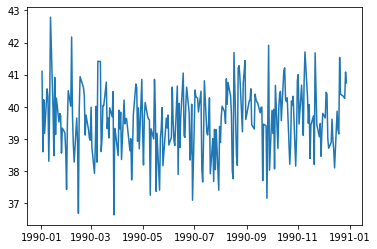

In [9]:
import matplotlib as mpl

import matplotlib.pyplot as plt

combined_spread=(optimal_weights*spreads_train).sum(axis=1) # linearly combine different spreads (training set)

combined_spread_mu=combined_spread.mean()
combined_spread_std=combined_spread.std()


plt.plot(combined_spread)

可以看到，mean-reverting portfolio optimization在训练集上的效果极好，在保持大方差（单次交易利润）的前提下，基本完全消除了时间序列上的相关性，均值回归的速度极快。

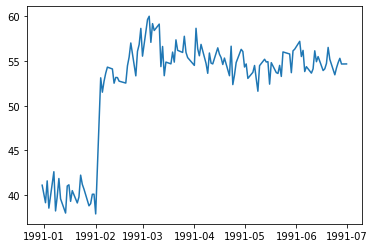

In [10]:
combined_spread=(optimal_weights*spreads_test).sum(axis=1) # linearly combine different spreads (testing set)

combined_spread_mu=combined_spread.mean()
combined_spread_std=combined_spread.std()


plt.plot(combined_spread)

<font color='red'>

测试集上其实也是牛的，但是中间发生了结构性改变，是由于rebalance频率太低导致的。需要潘神把rebalance频率提高

</font>

In [ ]:

weights_by_levels=pd.concat([comp_weights.reset_index(level=1),optimal_weights],axis=1) # different levels of weights, combined by pair index

weights_by_levels['flat_w']=weights_by_levels['component_w']*weights_by_levels['opt_w']
weights_single_stocks=weights_by_levels.groupby('stock')['flat_w'].sum()
weights_single_stocks

stock
AEP    -0.038985
AMRC    0.493419
ATO    -0.264892
BCE     0.010688
BIF     0.232257
BMY     0.076239
BTT    -0.007713
CMU     0.375293
CXE     0.290182
CXH    -0.119151
DSM     0.084848
FARM    0.008493
FPL     0.013645
FRST    0.027686
HE     -0.035832
HRB    -0.051966
IFF    -0.026585
IPW     0.065776
JHS    -0.067745
KTF     0.042468
LEO    -0.041858
MAYS   -0.141320
MCN     0.047446
MDU    -0.009854
MGEE   -0.029156
MGF    -0.193549
MHF    -0.112224
MSEX    0.141378
MVF     0.133742
MWV    -0.095280
NCA     0.050473
NJR     0.020049
NMI     0.317168
NNY    -0.005376
NUV     0.237710
OTTR   -0.015593
PCF     0.100776
PDI     0.061023
PEBK   -0.302367
PMM    -0.111106
SCP    -0.089738
TFB     0.201927
TRMK    0.033894
UHT    -0.261814
UNP    -0.004922
VXS    -0.044487
WAG     0.008596
WR     -0.003663
Name: flat_w, dtype: float64

<font color='red'>

请注意，weights_single_stocks的数值并不是指资金权重，而是log price线性组合的权重。需要潘神正确地处理这个逻辑，正确计算returns。

</font>

<font color='blue'>

潘神todos:

1. 把mean-reversion portfolio的交易逻辑写出来。
2. 把rebalancing的频率调成月频，滚动回测3个不同的optimizers。

</font>

<font color='green'>

与潘神确认：

1. beta是线性组合的权重，不是资金权重，是否有正确处理这个逻辑？
2. 

</font>